In this notebook, we will try to build a very simple model to predict the outcome of tennis matched.  This is an ELO model.  Specifically, we will model

$$p(y_1) = \sigma(\beta_1 - \beta_2)$$, where $$\beta_1$$ and $$\beta_2$$ are coefficients for players 1 and 2 respectively

In [1]:
from infra.defs import DATA_DIR
import pandas as pd
import os

match_result_dir = os.path.join(DATA_DIR, 'match_results')

df = pd.concat([
    pd.read_csv(os.path.join(match_result_dir, f)) for f in os.listdir(match_result_dir)
])

In [2]:
df.rename(columns={x: x.lower() for x in df.columns}, inplace=True)

In [3]:
# Drop rows with no result
import numpy as np

df.dropna(subset=['winner', 'loser'], inplace=True)
df['wrank'].replace('NR', np.nan, inplace=True)
df['lrank'].replace('NR', np.nan, inplace=True)
df['wrank'] = df['wrank'].astype(float)
df['lrank'] = df['lrank'].astype(float)

In [4]:
df.shape

(50784, 59)

50k matches to work with

In [5]:
df['match_id'] = range(df.shape[0])

In [6]:
# Convert dates to datetimes
df['date'] = pd.to_datetime(df['date']).astype(pd.Timestamp)

#### Explore Player Frequencies

In [7]:
df['winner'] = df['winner'].map(lambda x: x.strip())
df['loser'] = df['loser'].map(lambda x: x.strip())
player_set = set(df['winner']) | set(df['loser'])
n_players = len(player_set)
n_players

1396

In [8]:
sorted(player_set)

['Abdulla M.',
 'Abel M.',
 'Acasuso J.',
 'Adaktusson J.',
 'Agaev E.',
 'Agassi A.',
 'Agenor R.',
 'Ager J.',
 'Agostinelli B.',
 'Aguilar J.',
 'Ahouda A.',
 'Al Ghareeb M.',
 'Al Khulaifi N.G.',
 'Al Mutawa J.',
 'Al-Alawi S.K.',
 'Al-Ghareeb M.',
 'Alami K.',
 'Alawadhi O.',
 'Albert M.',
 'Albot R.',
 'Alcaide G.',
 'Aldi F.',
 'Ali Mutawa J.M.',
 'Allegro Y.',
 'Almagro N.',
 'Alonso J.',
 'Altamirano C.',
 'Altmaier D.',
 'Alund M.',
 'Alvarez E.',
 'Alves T.',
 'Amritraj P.',
 'Ancic I.',
 'Ancic M.',
 'Andersen J.',
 'Andersen J.F.',
 'Anderson A.',
 'Anderson K.',
 'Anderson O.',
 'Andersson H.',
 'Andreev A.',
 'Andreev I.',
 'Andreozzi G.',
 'Androic T.',
 'Andujar P.',
 'Aragone J.',
 'Aranguren J.M.',
 'Arazi H.',
 'Arguello F.',
 'Armando H.',
 'Arnaboldi A.',
 'Arnold L.',
 'Arquez P.',
 'Arthurs W.',
 'Artunedo Martinavarro A.',
 'Arvidsson I.',
 'Ascione A.',
 'Ascione T.',
 'Auckland J.',
 'Auger-Aliassime F.',
 'Authom M.',
 'Awadhy O.',
 'Ayala D.',
 'Azzaro L.',

1396 total players.  Let's look at player frequency:

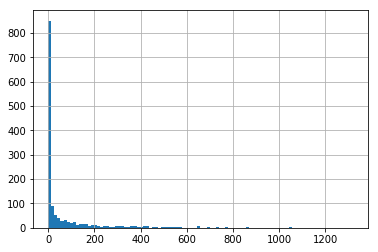

In [9]:
%matplotlib inline
all_players = pd.Series(df['winner'].tolist() + df['loser'].tolist())
all_players.value_counts().hist(bins=100)

There is clearly a long tail.  There are certain players that have played a lot of matches over this time period, and lots of players with very few

In [10]:
all_players.value_counts().value_counts().head()

1    314
2    163
3     84
4     59
5     49
dtype: int64

In [11]:
all_players.value_counts().head(20)

Federer R.          1318
Nadal R.            1051
Ferrer D.           1042
Djokovic N.          919
Berdych T.           888
Youzhny M.           865
Robredo T.           864
Lopez F.             858
Verdasco F.          854
Murray A.            806
Davydenko N.         794
Gasquet R.           773
Roddick A.           773
Kohlschreiber P.     730
Hewitt L.            727
Simon G.             724
Wawrinka S.          701
Nieminen J.          697
Haas T.              691
Ferrero J.C.         683
dtype: int64

The players who appear most often are the best players...

#### Get player indices

In [12]:
player_idx_dict = dict(list(enumerate(player_set)))
player_mapping = {v: k for k, v in player_idx_dict.iteritems()}

In [13]:
n_players = len(player_mapping)
n_players

1396

In [14]:
df['winner_idx'] = df['winner'].map(lambda x: player_mapping[x])
df['loser_idx'] = df['loser'].map(lambda x: player_mapping[x])

#### Set up training data

First, we'll just try training on everything in this time period and see what happens.  Later, we will split into train and test sets and figure out appropriate discounting, etc.

In [15]:
from scipy.sparse import csc_matrix, hstack
import numpy as np


N_PLAYERS = len(player_mapping)

def _get_sparse_X(df):
    n = df.shape[0]
    p1_data = np.ones(n)
    p1_row = np.arange(n)
    p1_col = df['p1_idx'].values

    p2_data = -np.ones(n)
    p2_row = np.arange(n)
    p2_col = df['p2_idx'].values

    all_data = np.concatenate([p1_data, p2_data])
    all_row = np.concatenate([p1_row, p2_row])
    all_col = np.concatenate([p1_col, p2_col])

    X = csc_matrix((all_data, (all_row, all_col)), shape=(n, N_PLAYERS))
    return X


def _randomize_result(df):
    df['__chooser__'] = np.random.binomial(1, 0.5, size=df.shape[0])
    df['p1_idx'] = df.apply(
        lambda row: row['winner_idx'] if row['__chooser__'] == 1 else row['loser_idx'],
        axis=1
    )
    df['p2_idx'] = df.apply(
        lambda row: row['winner_idx'] if row['__chooser__'] == 0 else row['loser_idx'],
        axis=1
    )
    df['p1_rank'] = df.apply(
        lambda row: row['wrank'] if row['__chooser__'] == 1 else row['lrank'],
        axis=1
    )
    df['p2_rank'] = df.apply(
        lambda row: row['wrank'] if row['__chooser__'] == 0 else row['lrank'],
        axis=1
    )
    df['y'] = df['__chooser__']
    

def get_X_y(df, include_ranks=False, nan_fill=500.):
    if 'p1_idx' not in df or 'p2_idx' not in df:
        # Shuffle winners and losers so y can have both 0's and 1's.
        _randomize_result(df)
    X = _get_sparse_X(df)
    assert ((X != 0).sum(axis=1) == 2).all()
    if include_ranks:
        ranks = csc_matrix(df[['p1_rank', 'p2_rank']].fillna(nan_fill).values)
        X = hstack([X, ranks])
    return X, df['y'].values

X, y = get_X_y(df, include_ranks=True)

In [16]:
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(fit_intercept=False)
logit.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [17]:
def describe_result(logit_mod):
    coef_df = pd.DataFrame(
        list(enumerate(logit_mod.coef_[0][:N_PLAYERS])),
        columns=['player_idx', 'coef']
    )
    coef_df['player_name'] = coef_df['player_idx'].map(lambda x: player_idx_dict[x])
    return coef_df.sort_values(by='coef', ascending=False)

describe_result(logit)

,player_idx,coef,player_name
2,2,2.597897,Djokovic N.
766,766,2.458868,Federer R.
51,51,2.427203,Nadal R.
271,271,2.138244,Murray A.
713,713,1.805777,Del Potro J.M.
1198,1198,1.743778,Roddick A.
902,902,1.669760,Agassi A.
1171,1171,1.517095,Tsonga J.W.
1023,1023,1.503589,Hewitt L.
80,80,1.455861,Sampras P.


#### Tune Time-Decay and Regularization

There is an argument that we should not be regularizing towards 0.  Players that appear infrequently are probably wors -- they qualify for fewer tournaments and progress to later rounds of tournaments less often.  For now however, we will continue to regularize towards 0.  Here, we investigate the following:

* What time decay weight is most predictive?
* How much regularization should we use?

In [28]:
# Start by updating model every New Year's Day
BURN_IN_DATE = 2010
END_DATE = 2019
TIME_BREAKS = ['%d-01-01' % year for year in range(BURN_IN_DATE, END_DATE)]
TIME_BREAKS = map(pd.to_datetime, TIME_BREAKS)
TIME_BREAKS

[Timestamp('2010-01-01 00:00:00'),
 Timestamp('2011-01-01 00:00:00'),
 Timestamp('2012-01-01 00:00:00'),
 Timestamp('2013-01-01 00:00:00'),
 Timestamp('2014-01-01 00:00:00'),
 Timestamp('2015-01-01 00:00:00'),
 Timestamp('2016-01-01 00:00:00'),
 Timestamp('2017-01-01 00:00:00'),
 Timestamp('2018-01-01 00:00:00')]

In [67]:
def fit_model(train_X, train_y, test_X, test_y, weights=None, C=1.0):
    logit = LogisticRegression(C=C, fit_intercept=False)
    if weights is None:
        weights = np.ones(train_X.shape[0])
    logit.fit(train_X, train_y, sample_weight=weights)
    preds = logit.predict_proba(test_X)[:, 1] 
    class_preds = logit.predict(test_X)
    return logit, preds, class_preds


def _get_weights(cur_time, train_df, halflife):
    if halflife is None:
        weights = np.ones(train_df.shape[0])
    else:
        # NOTE: Can make this much faster by preloading integer days
        days_ago = (pd.to_datetime(cur_time) - train_df['date']).map(lambda x: x.days)
        lamb = np.log(2) / halflife
        weights = np.exp(-lamb * days_ago.astype(float))
    return weights

Let's confirm that get_weights is doing what it's supposed to be doing:

In [68]:
weights = _get_weights(df['date'].max(), df, 365.)

In [74]:
weights.head(10000)

0       0.000003
1       0.000003
2       0.000003
3       0.000003
4       0.000003
5       0.000003
6       0.000003
7       0.000003
8       0.000003
9       0.000003
10      0.000003
11      0.000003
12      0.000003
13      0.000003
14      0.000003
15      0.000003
16      0.000003
17      0.000003
18      0.000003
19      0.000003
20      0.000003
21      0.000003
22      0.000003
23      0.000003
24      0.000003
25      0.000003
26      0.000003
27      0.000003
28      0.000003
29      0.000003
          ...   
1190    0.000030
1191    0.000030
1192    0.000030
1193    0.000030
1194    0.000030
1195    0.000030
1196    0.000030
1197    0.000030
1198    0.000030
1199    0.000030
1200    0.000030
1201    0.000030
1202    0.000030
1203    0.000030
1204    0.000030
1205    0.000030
1206    0.000030
1207    0.000030
1208    0.000031
1209    0.000031
1210    0.000031
1211    0.000031
1212    0.000031
1213    0.000031
1214    0.000031
1215    0.000031
1216    0.000031
1217    0.0000

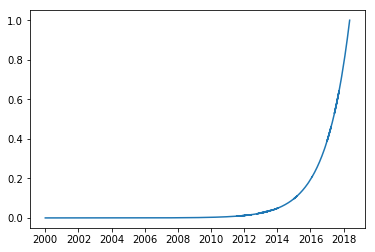

In [72]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.plot(df['date'], weights)

Looks like the weighting is doing roughly what it is supposed to...

In [64]:
from sklearn.metrics import roc_auc_score

def eval_model(C=1.0, halflife=None, max_rank=None, include_ranks=False):
    if max_rank is not None:
        _df = df[
            (df['wrank'] < max_rank) &
            (df['lrank'] < max_rank)
        ].copy()
    else:
        _df = df.copy()
        
    mods = []
    out = []
    _df['__weight__'] = 10000 *_get_weights(
        _df['date'].max(),
        _df,
        halflife
    )
    for i in range(len(TIME_BREAKS)):
        cur_break = TIME_BREAKS[i]
        if i + 1 == len(TIME_BREAKS):
            next_break = pd.to_datetime('2099-12-31')
        else:
            next_break = TIME_BREAKS[i + 1]
        print cur_break, next_break
        train_df = _df[_df['date'] < cur_break]
        test_df = _df[
            (_df['date'] >= cur_break) &
            (_df['date'] < next_break)
        ]
        train_X, train_y = get_X_y(train_df, include_ranks=include_ranks)
        test_X, test_y = get_X_y(test_df, include_ranks=include_ranks)
        mod, preds, class_preds = fit_model(train_X, train_y, test_X, test_y, C=C, weights=train_df['__weight__'])
        mods.append(mod)
        out.extend(zip(test_df['match_id'].tolist(), preds.tolist(), class_preds.tolist()))
    out_df = pd.DataFrame(out, columns=['match_id', 'pred', 'class_pred'])
    final_df = pd.merge(_df, out_df, on='match_id')

    if max_rank is not None:
        rel = final_df[
            (final_df['lrank'] < max_rank) &
            (final_df['wrank'] < max_rank)
        ]
    else:
        rel = final_df

    auc = roc_auc_score(rel['y'], rel['pred'])
    accuracy = (rel['y'] == rel['class_pred']).mean() 
    print auc, accuracy
    return mods, out, final_df, auc, accuracy 

In [47]:
out = []
for C in [0.001, 0.01, 0.1, 1., 10.]:
    for hl in [45., 90., 180., 365., 730., 1460.]:
        print C, hl
        _, _, _, auc, accuracy = eval_model(halflife=hl, C=C)
        out.append((C, hl, auc, accuracy))
out

0.001 45.0
2010-01-01 00:00:00 2011-01-01 00:00:00
2011-01-01 00:00:00 2012-01-01 00:00:00
2012-01-01 00:00:00 2013-01-01 00:00:00
2013-01-01 00:00:00 2014-01-01 00:00:00
2014-01-01 00:00:00 2015-01-01 00:00:00
2015-01-01 00:00:00 2016-01-01 00:00:00
2016-01-01 00:00:00 2017-01-01 00:00:00
2017-01-01 00:00:00 2018-01-01 00:00:00
2018-01-01 00:00:00 2099-12-31 00:00:00
0.583329896662 0.559809043416
0.001 90.0
2010-01-01 00:00:00 2011-01-01 00:00:00
2011-01-01 00:00:00 2012-01-01 00:00:00
2012-01-01 00:00:00 2013-01-01 00:00:00
2013-01-01 00:00:00 2014-01-01 00:00:00
2014-01-01 00:00:00 2015-01-01 00:00:00
2015-01-01 00:00:00 2016-01-01 00:00:00
2016-01-01 00:00:00 2017-01-01 00:00:00
2017-01-01 00:00:00 2018-01-01 00:00:00
2018-01-01 00:00:00 2099-12-31 00:00:00
0.625972213161 0.619708160692
0.001 180.0
2010-01-01 00:00:00 2011-01-01 00:00:00
2011-01-01 00:00:00 2012-01-01 00:00:00
2012-01-01 00:00:00 2013-01-01 00:00:00
2013-01-01 00:00:00 2014-01-01 00:00:00
2014-01-01 00:00:00 2015-0

2015-01-01 00:00:00 2016-01-01 00:00:00
2016-01-01 00:00:00 2017-01-01 00:00:00
2017-01-01 00:00:00 2018-01-01 00:00:00
2018-01-01 00:00:00 2099-12-31 00:00:00
0.712423498302 0.658800216177
1.0 365.0
2010-01-01 00:00:00 2011-01-01 00:00:00
2011-01-01 00:00:00 2012-01-01 00:00:00
2012-01-01 00:00:00 2013-01-01 00:00:00
2013-01-01 00:00:00 2014-01-01 00:00:00
2014-01-01 00:00:00 2015-01-01 00:00:00
2015-01-01 00:00:00 2016-01-01 00:00:00
2016-01-01 00:00:00 2017-01-01 00:00:00
2017-01-01 00:00:00 2018-01-01 00:00:00
2018-01-01 00:00:00 2099-12-31 00:00:00
0.725814532227 0.668888488561
1.0 730.0
2010-01-01 00:00:00 2011-01-01 00:00:00
2011-01-01 00:00:00 2012-01-01 00:00:00
2012-01-01 00:00:00 2013-01-01 00:00:00
2013-01-01 00:00:00 2014-01-01 00:00:00
2014-01-01 00:00:00 2015-01-01 00:00:00
2015-01-01 00:00:00 2016-01-01 00:00:00
2016-01-01 00:00:00 2017-01-01 00:00:00
2017-01-01 00:00:00 2018-01-01 00:00:00
2018-01-01 00:00:00 2099-12-31 00:00:00
0.724506087484 0.669023599351
1.0 1460.0

[(0.001, 45.0, 0.58332989666222745, 0.55980904341560078),
 (0.001, 90.0, 0.62597221316121088, 0.61970816069176726),
 (0.001, 180.0, 0.66572130017434006, 0.63767789587461721),
 (0.001, 365.0, 0.71582488994694637, 0.65866510538641687),
 (0.001, 730.0, 0.72848088868347383, 0.66677175283732659),
 (0.001, 1460.0, 0.72522850644567105, 0.66632138353449832),
 (0.01, 45.0, 0.59584080067267287, 0.57755359394703654),
 (0.01, 90.0, 0.63510392765220858, 0.62448207530174749),
 (0.01, 180.0, 0.68167114026183495, 0.6462799495586381),
 (0.01, 365.0, 0.72676414875195539, 0.66551071878940726),
 (0.01, 730.0, 0.72658674269159196, 0.66771752837326603),
 (0.01, 1460.0, 0.7228450617851534, 0.66668167897676089),
 (0.1, 45.0, 0.604791080835267, 0.59178526391641151),
 (0.1, 90.0, 0.64642860611305453, 0.63069717168077821),
 (0.1, 180.0, 0.69722879823344908, 0.65290037831021441),
 (0.1, 365.0, 0.72719329519652043, 0.66785263916411453),
 (0.1, 730.0, 0.72505549780983514, 0.66888848856061967),
 (0.1, 1460.0, 0.7220

In [75]:
mods, _, _, _, _ = eval_model(C=0.01, halflife=730, max_rank=None, include_ranks=False)

2010-01-01 00:00:00 2011-01-01 00:00:00
2011-01-01 00:00:00 2012-01-01 00:00:00
2012-01-01 00:00:00 2013-01-01 00:00:00
2013-01-01 00:00:00 2014-01-01 00:00:00
2014-01-01 00:00:00 2015-01-01 00:00:00
2015-01-01 00:00:00 2016-01-01 00:00:00
2016-01-01 00:00:00 2017-01-01 00:00:00
2017-01-01 00:00:00 2018-01-01 00:00:00
2018-01-01 00:00:00 2099-12-31 00:00:00
0.726586742692 0.667717528373


In [55]:
final_df.shape

(22204, 71)

In [56]:
df[df['date'] >= pd.to_datetime('2010-01-01')].shape

(22204, 69)

In [57]:
for tb, mod in zip(TIME_BREAKS, mods):
    print '\n' + str(tb)
    print '\n---------------------------'
    print describe_result(mod).head(10)


2010-01-01 00:00:00

---------------------------
      player_idx      coef     player_name
766          766  4.155474      Federer R.
51            51  3.947577        Nadal R.
2              2  3.648762     Djokovic N.
271          271  3.536922       Murray A.
1198        1198  3.241497      Roddick A.
713          713  3.048184  Del Potro J.M.
902          902  2.855689       Agassi A.
1171        1171  2.819505     Tsonga J.W.
1241        1241  2.775554   Nalbandian D.
1023        1023  2.759327       Hewitt L.

2011-01-01 00:00:00

---------------------------
      player_idx      coef     player_name
766          766  4.174743      Federer R.
51            51  4.091400        Nadal R.
2              2  3.635317     Djokovic N.
271          271  3.512574       Murray A.
1198        1198  3.207438      Roddick A.
713          713  3.030404  Del Potro J.M.
1241        1241  2.942290   Nalbandian D.
902          902  2.881745       Agassi A.
287          287  2.875259    Soderling 

#### Naive Model that only uses rank to make class predictions

In [103]:
df['rank_pred'] = (df['p1_rank'] < df['p2_rank'])
rel_df = df[
    (df['date'] > TIME_BREAKS[0]) &
    df['p1_rank'].notnull() &
    df['p2_rank'].notnull()
]
(rel_df['rank_pred'] == rel_df['y']).mean()

0.66603484068959296

66.6% from using rank alone...but this_updates_constantly and this only looks at matches where both players have rankings...

In [97]:
# Get year end rankings
rank_df = df.copy()
rank_df['year'] = rank_df['date'].map(lambda x: x.year)
_winner_rank_df = rank_df.groupby(['year', 'winner']).apply(
    lambda x: x[['year', 'winner', 'date', 'wrank']].iloc[-1]
).reset_index(drop=True)
_winner_rank_df.rename(columns={'winner': 'player'}, inplace=True)
_winner_rank_df.rename(columns={'wrank': 'ye_rank'}, inplace=True)

_loser_rank_df = rank_df.groupby(['year', 'loser']).apply(
    lambda x: x[['year', 'loser', 'date', 'lrank']].iloc[-1]
).reset_index(drop=True)
_loser_rank_df.rename(columns={'loser': 'player'}, inplace=True)
_loser_rank_df.rename(columns={'lrank': 'ye_rank'}, inplace=True)

tot_rank_df = pd.concat([_winner_rank_df, _loser_rank_df])
tot_rank_df.sort('date', ascending=True, inplace=True)
year_end_rankings = tot_rank_df.drop_duplicates(['player', 'year'], take_last=True)

/Users/siddhantjagadish/Documents/DataProjects/tennis_modeling/tennis_modeling/lib/python2.7/site-packages/ipykernel_launcher.py:17: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/Users/siddhantjagadish/Documents/DataProjects/tennis_modeling/tennis_modeling/lib/python2.7/site-packages/ipykernel_launcher.py:18: FutureWarning: the take_last=True keyword is deprecated, use keep='last' instead


In [98]:
_for_merge = year_end_rankings.copy()
_for_merge['year'] += 1  # Want to match year end rankings for 2000 with matches in 2001

In [102]:
rank_df = pd.merge(
    rank_df,
    _for_merge,
    left_on=['winner', 'year'],
    right_on=['player', 'year']
)
rank_df.rename(columns={'ye_rank': 'winner_ye_rank'}, inplace=True)

rank_df = pd.merge(
    rank_df,
    _for_merge,
    left_on=['loser', 'year'],
    right_on=['player', 'year']
)
rank_df.rename(columns={'ye_rank': 'loser_ye_rank'}, inplace=True)

In [104]:
rel_df = rank_df[
    (rank_df['date'] > TIME_BREAKS[0]) &
    rank_df['winner_ye_rank'].notnull() &
    rank_df['loser_ye_rank'].notnull()
]
(rank_df['winner_ye_rank'] < rank_df['loser_ye_rank']).mean()

0.64128541303749886

Only 64% accuracy when we use year-end rankings so apples-to-apples time comparison and can't update rank all the time